In [1]:
import os
import uproot
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import mplhep as hep
plt.style.use(hep.style.CMS)
import numpy as np
import hist
import hist.plot
import hist.intervals
import json

In [4]:
ht_names = [f"wjets_ht{bin}" for bin in range(1, 9)]

In [36]:
def plot(folder, suffix=""):
    dir_ht_binned = uproot.open(f"{folder}root/LHE_HT{suffix}__pg_wjets_mlm_HT__nodata.root:histograms")
    with open(f"{folder}yields/LHE_HT{suffix}__pg_wjets_mlm_HT__nodata.json", "r") as f:
        ht_binned_yields = json.load(f)
    inclusive = uproot.open(f"{folder}root/LHE_HT{suffix}__pg_wjets_mlm__nodata.root:histograms")["wjets_mlm"]
    with open(f"{folder}yields/LHE_HT{suffix}__pg_wjets_mlm__nodata.json", "r") as f:
        inclusive_yields = json.load(f)
    
    fig = plt.figure()
    grid = fig.add_gridspec(2, 1, hspace=0.07, height_ratios=[3, 1])

    main_ax:plt.Axes = fig.add_subplot(grid[0])
    subplot_ax:plt.Axes = fig.add_subplot(grid[1], sharex=main_ax)

    ht_binned_artists = hep.histplot([dir_ht_binned[name] for name in ht_names], yerr=True, label=[f"HT bin {bin}" for bin in range(1, 9)], flow="none", ax=main_ax)
    incl_artists = hep.histplot(inclusive, label="Inclusive", yerr=True, histtype="errorbar", flow="none", color="black", markersize=5, ax=main_ax)

    scale_inclusive = inclusive_yields["wjets_mlm"]["Entries"] / inclusive_yields["wjets_mlm"]["Total yield"]
    with np.errstate(divide="ignore", invalid="ignore"):
        inclusive_h = inclusive.to_hist()
        for ht_bin in ht_names:
            binned_h = dir_ht_binned[ht_bin].to_hist()
            scale_binned = ht_binned_yields[ht_bin]["Entries"] / ht_binned_yields[ht_bin]["Total yield"]

            ratio = binned_h.values() / inclusive_h.values()
            # if ht_bin == "wjets_ht2":
            #     ratio *= 1346.0/1244.0
            ratio_uncert = hist.intervals.ratio_uncertainty(
                num=binned_h.values() * scale_binned,
                denom=inclusive_h.values() * scale_inclusive,
                uncertainty_type="poisson-ratio",
            ) *scale_inclusive / scale_binned
            hist.plot.plot_ratio_array(binned_h, ratio, ratio_uncert, subplot_ax, ylim=(0.8,1.2), markersize=5)
        # hep.histplot(ratio, yerr=False, histtype="errorbar", ax=subplot_ax)

    main_ax.set_yscale("log")
    if suffix == "_high":
        main_ax.set_ylim(bottom=1)
        subplot_ax.set_ylim(0.5, 1.5)
    else:
        main_ax.set_ylim(bottom=1e3)
    if suffix == "":
        plt.xlim(0, 1e3)
    elif suffix == "_low":
        plt.xlim(0, 130)
    elif suffix == "_high":
        plt.xlim(0, 3000)
    plt.setp(main_ax.get_xticklabels(), visible=False)
    main_ax.legend(incl_artists + ht_binned_artists, ["Inclusive"] + [f"HT bin {bin}" for bin in range(1, 9)])
    subplot_ax.set_xlabel("LHE HT (GeV)")
    subplot_ax.grid(axis="y", which="both")
    subplot_ax.set_ylabel("HT-binned/Inclusive", size=20)
    main_ax.set_ylabel("Events")
    hep.cms.text("Simulation Preliminary", fontsize=25, ax=main_ax)
    lumi = 59741
    hep.cms.lumitext(f"2018, 13 TeV (${lumi/ 1000:.1f}\/""fb^{-1}$)", fontsize=20, ax=main_ax)

/opt/exp_soft/llr/python/3.11.8/el7/lib/python3.11/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)
/opt/exp_soft/llr/python/3.11.8/el7/lib/python3.11/site-packages/mplhep/utils.py:197: RuntimeWarning: All sumw are zero!  Cannot compute meaningful error bars
  return np.abs(method_fcn(self.values, variances) - self.values)


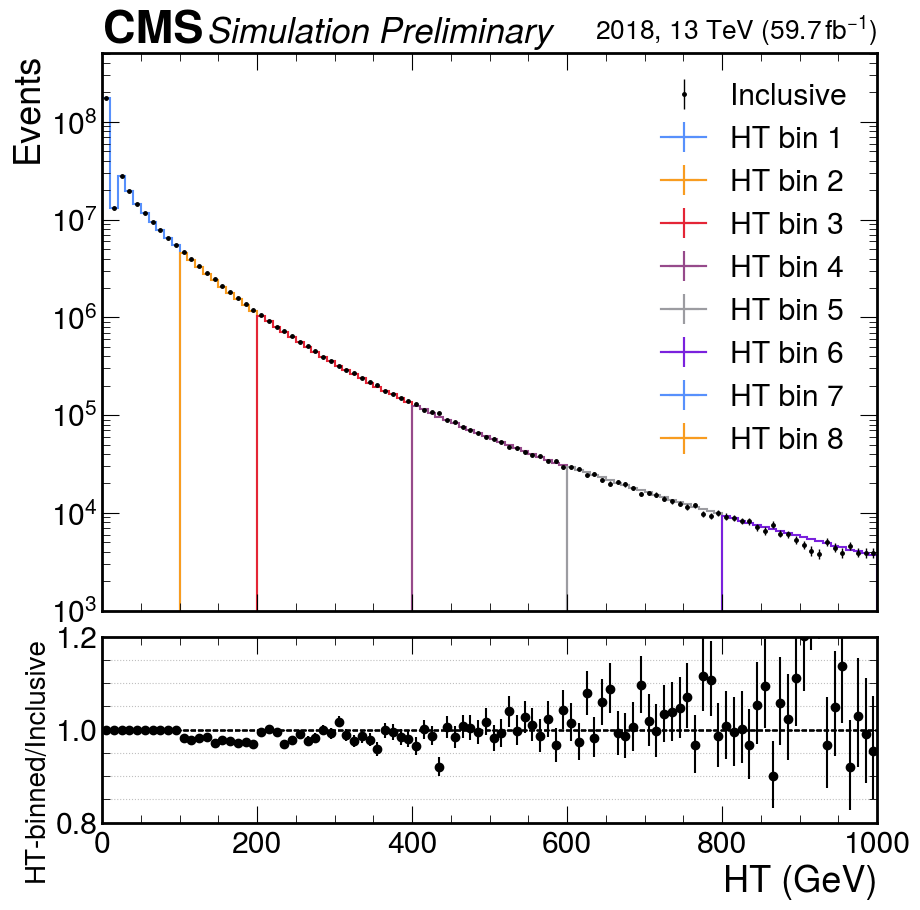

In [38]:
plot("/grid_mnt/data__data.polcms/cms/cuisset/cmt/FeaturePlot/ul_2018_ZZ_v12/cat_base_fixedGenWeight/prod_240411/")
plt.savefig("/grid_mnt/data__data.polcms/cms/cuisset/cmt/NicePlots/stitching/wjets/2018.pdf", bbox_inches="tight")

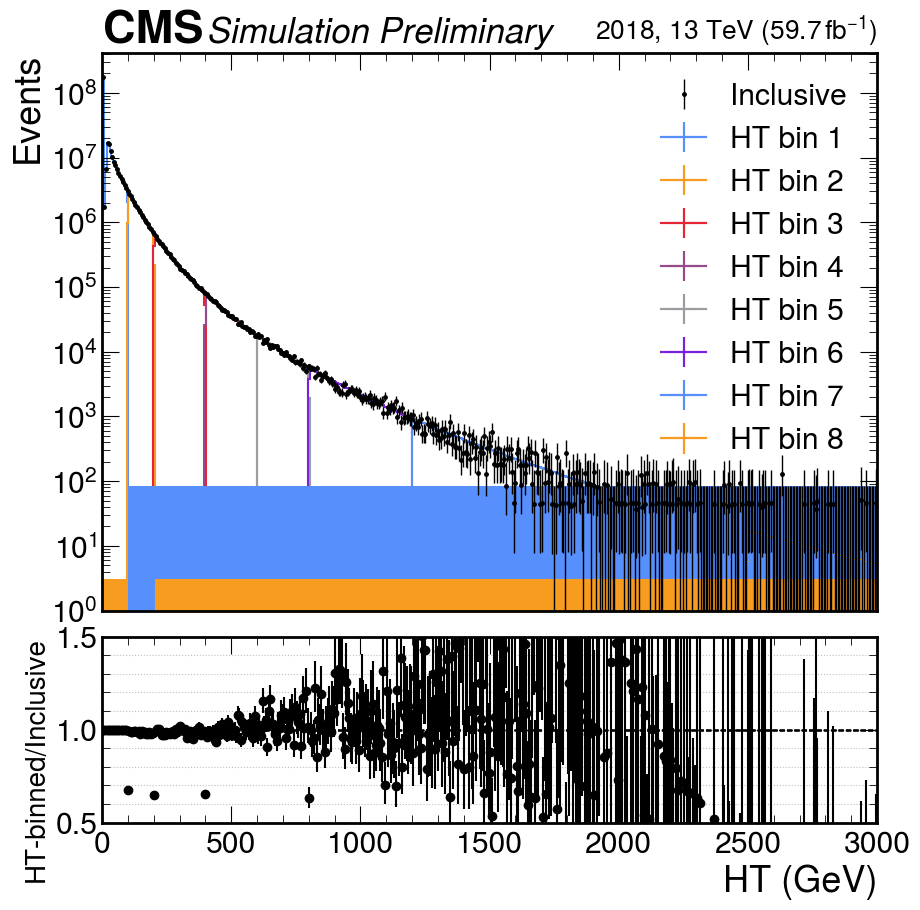

In [29]:
plot("/grid_mnt/data__data.polcms/cms/cuisset/cmt/FeaturePlot/ul_2018_ZZ_v12/cat_base_fixedGenWeight/prod_240411/", "_high")